In [1]:
import os
import numpy as np
import pandas as pd
import scanpy as sc
# import squidpy as sq

# import muon as mu
import mudata as mu

In [2]:
import liana as li

In [3]:
## load slide
slide = "B1"
exp = "V11L12-109" # V11T17-102 V11L12-109 V11T16-085
slide_path = f"data/VicariEtAl/sma/{exp}/{exp}_{slide}/output_data"

NOTE: This requires coordinates to be in the same system (e.g. pixels on the image)

In [4]:
mdata = mu.read_h5mu(os.path.join(slide_path, "sma.h5mu"))
rna = mdata.mod["rna"]
msi = mdata.mod["msi"]

/home/dbdimitrov/anaconda3/envs/spiana/lib/python3.10/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
/home/dbdimitrov/anaconda3/envs/spiana/lib/python3.10/site-packages/mudata/_core/mudata.py:446: UserWarning: var_names are not unique. To make them unique, call `.var_names_make_unique`.


In [5]:
rna.var_names_make_unique()
msi.var_names_make_unique()

In [6]:
mdata

MuData object with n_obs × n_vars = 6125 × 33823
  2 modalities
    rna:	3120 x 32285
      obs:	'in_tissue', 'array_row', 'array_col', 'x', 'y', 'lesion', 'region'
      var:	'gene_ids', 'feature_types', 'genome'
      uns:	'spatial'
      obsm:	'spatial'
    msi:	3005 x 1538
      obs:	'leiden', 'array_row', 'array_col', 'x', 'y'
      var:	'mean', 'std'
      uns:	'leiden_colors', 'spatial'
      obsm:	'X_pca', 'spatial'
      varm:	'PCs'
      obsp:	'connectivities', 'distances'

## Process RNA

In [7]:
sc.pp.filter_cells(rna, min_genes=200)
sc.pp.filter_cells(rna, min_counts=100)
sc.pp.filter_genes(rna, min_cells=3)

In [8]:
sc.pp.normalize_total(rna, target_sum=1e4)
sc.pp.log1p(rna)

In [9]:

sc.pp.highly_variable_genes(rna, flavor='cell_ranger', n_top_genes=200)

In [10]:
rna = rna[:, rna.var['highly_variable']]

In [11]:
rna

View of AnnData object with n_obs × n_vars = 3050 × 200
    obs: 'in_tissue', 'array_row', 'array_col', 'x', 'y', 'lesion', 'region', 'n_genes', 'n_counts'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'spatial', 'log1p', 'hvg'
    obsm: 'spatial'

## Process metabolites

In [12]:
# change type to float
msi.var['mz'] = msi.var.index.astype(float)
# round to 2 decimals
msi.var['mz'] = [round(x, 2) for x in msi.var['mz']]

In [13]:
msi.var['max_intensity'] = msi.X.sum(axis=0)

In [14]:
molecule_weights = {
    'GABA': 371.18,
    'GABA-H2O': 353.16,
    'Taurine': 393.13,
    'Serotonin': 444.21,
    'Histidine': 423.18,
    '3-MT': 435.21,
    'Dopamine (single)': 421.19,
    'Dopamine (double)': 674.28,
    'DOPAC': 689.24,
    'NE (Norepinephrine)': 690.28,
    'Tocopherol': 698.49
}

In [15]:
# show m/z with matching molecule weight
msk = msi.var['mz'].isin(molecule_weights.values())

In [16]:
msi = msi[:, msk]

In [17]:
msi.var['name'] = msi.var['mz'].map({v: k for k, v in molecule_weights.items()})
msi.var['name'] = msi.var['name'].astype('category')
msi.var.index = msi.var['name']

/tmp/ipykernel_94071/1051884205.py:1: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.


In [18]:
from matplotlib import pyplot as plt

In [19]:
msi.X.sum(axis=1)

array([-0.7011012 , -0.95237535, -0.93106604, ..., -2.3950171 ,
       -0.74203223, -2.216792  ], dtype=float32)

(array([971., 389., 399., 284., 215., 187., 129., 126.,  73.,  59.,  58.,
         36.,  18.,  20.,  13.,   9.,   8.,   5.,   2.,   2.,   0.,   0.,
          1.,   0.,   1.]),
 array([-2.3950171e+00, -1.2054020e+00, -1.5786991e-02,  1.1738281e+00,
         2.3634431e+00,  3.5530581e+00,  4.7426734e+00,  5.9322882e+00,
         7.1219034e+00,  8.3115187e+00,  9.5011339e+00,  1.0690749e+01,
         1.1880363e+01,  1.3069979e+01,  1.4259594e+01,  1.5449209e+01,
         1.6638824e+01,  1.7828440e+01,  1.9018055e+01,  2.0207670e+01,
         2.1397284e+01,  2.2586899e+01,  2.3776514e+01,  2.4966129e+01,
         2.6155745e+01,  2.7345360e+01], dtype=float32),
 <BarContainer object of 25 artists>)

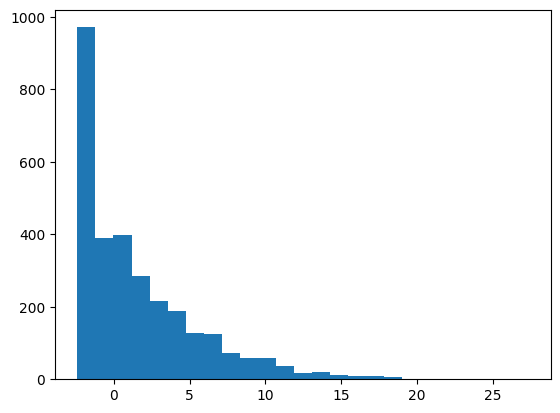

In [20]:
x = msi.X.sum(axis=1)

# histogram of total ion count
plt.hist(np.array(x), bins=25)

Test

In [21]:
# get reference coordinates
reference = mdata.mod["rna"].obsm["spatial"]

# distances of metabolties to RNA
li.ut.spatial_neighbors(msi, bandwidth=500, cutoff=0.1, spatial_key="spatial", reference=reference, set_diag=False, standardize=False)

/home/dbdimitrov/anaconda3/envs/spiana/lib/python3.10/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.


In [22]:
# get reference coordinates
reference = mdata.mod["msi"].obsm["spatial"]

# distances of metabolties to RNA
li.ut.spatial_neighbors(rna, bandwidth=500, cutoff=0.1, spatial_key="spatial", reference=reference, set_diag=False, standardize=False)

/home/dbdimitrov/anaconda3/envs/spiana/lib/python3.10/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.


In [23]:
import squidpy as sq

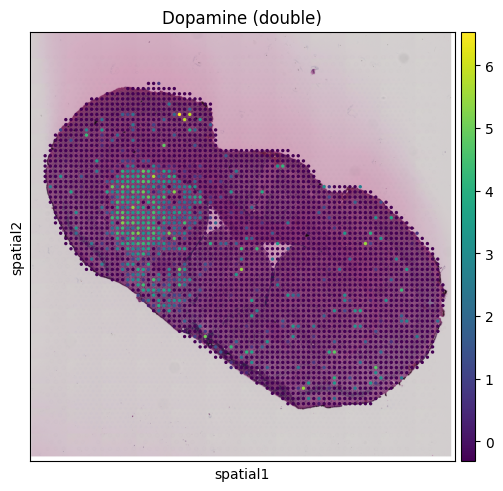

In [24]:
sq.pl.spatial_scatter(msi, color="Dopamine (double)")

In [25]:
# spatial weight all as 1
# w = np.zeros((msi.obsm['spatial_connectivities'].T.shape))

In [26]:
w = msi.obsm['spatial_connectivities'].T

In [27]:
# Apply Spatial Smoothing with RNA as reference
msi_smooth = w @ msi.X

In [28]:
msi_smooth = sc.AnnData(X=msi_smooth, obs=rna.obs, obsm=rna.obsm, uns=rna.uns, var=msi.var)

/home/dbdimitrov/anaconda3/envs/spiana/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.


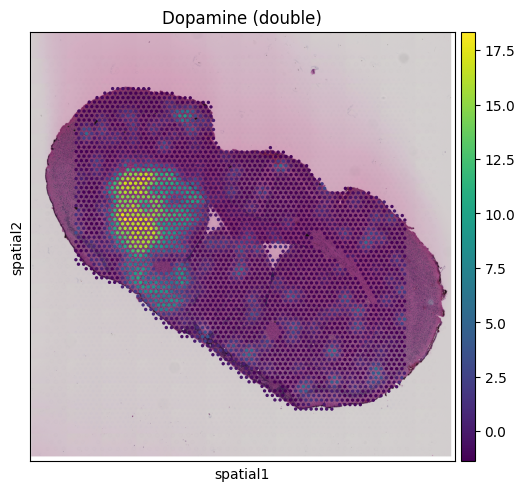

In [29]:
sq.pl.spatial_scatter(msi_smooth, color="Dopamine (double)")

Mitsy

In [30]:
mdata.update_obs()

In [31]:
misty = li.mt.MistyData({"intra": msi, "inter":rna}, enforce_obs=False, obs=mdata.obs)


view intra is not a csr_matrix. Converting to csr_matrix


In [32]:
misty(model="linear", verbose=True, bypass_intra=True)

Now learning: Tocopherol: 100%|██████████| 8/8 [00:09<00:00,  1.22s/it]       


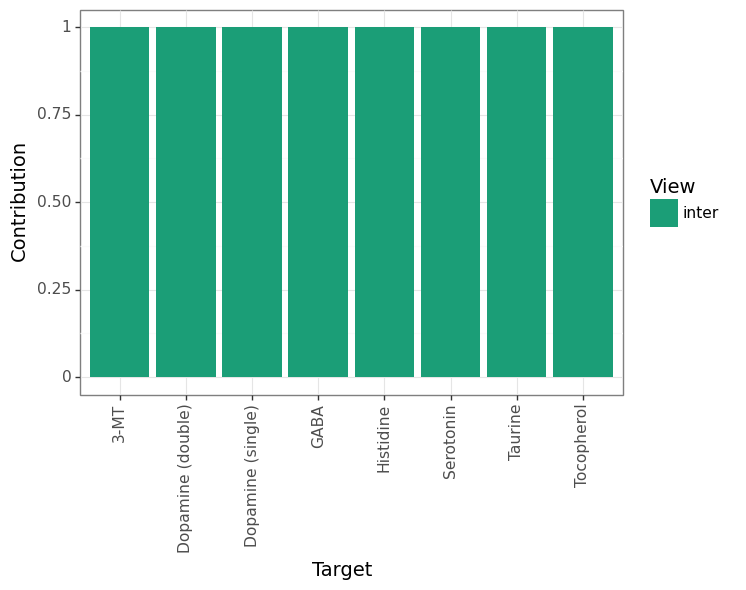

<ggplot: (8741769900735)>

In [33]:
# NOTE: why is stat being passed here and why does it work?....
li.pl.contributions(misty, return_fig=True)

In [34]:
misty.uns['target_metrics']

,target,intra_R2,multi_R2,gain_R2,inter
0,GABA,0,0.000000,0.000000,1.0
1,Taurine,0,0.000000,0.000000,1.0
2,Dopamine (single),0,0.037056,0.037056,1.0
3,Histidine,0,0.000000,0.000000,1.0
4,3-MT,0,0.623261,0.623261,1.0
5,Serotonin,0,0.000000,0.000000,1.0
6,Dopamine (double),0,0.346425,0.346425,1.0
7,Tocopherol,0,0.000000,0.000000,1.0


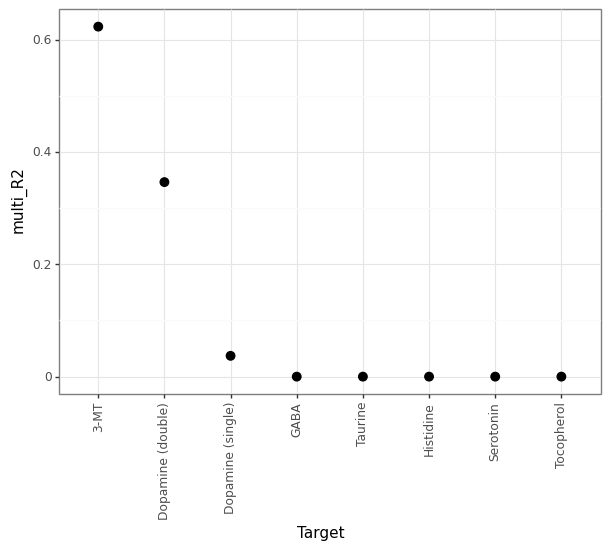

<ggplot: (8741765270691)>

In [35]:
li.pl.target_metrics(misty, stat='multi_R2', return_fig=True)


In [36]:
misty.uns['interactions'].sort_values("importances")

,target,predictor,view,importances
933,3-MT,Penk,inter,-19.801613
1333,Dopamine (double),Penk,inter,-12.993992
990,3-MT,Tspan15,inter,-5.377327
817,3-MT,Car14,inter,-5.191417
819,3-MT,Cartpt,inter,-4.696701
...,...,...,...,...
974,3-MT,Syndig1l,inter,5.978412
1358,Dopamine (double),Scn4b,inter,7.581708
958,3-MT,Scn4b,inter,7.830997
976,3-MT,Tac1,inter,10.744720


In [39]:
from sklearn.neighbors import BallTree
import plotnine as p9

In [53]:
def query_bandwidth(coordinates, start=0, end=500, interval_n=50, reference=None, inplace=False):
    tree = BallTree(coordinates, metric='euclidean')

    # initialize df
    df = pd.DataFrame()

    # Specify a range of max distances
    interval = np.linspace(start, end, interval_n)
    
    if reference is None:
        _reference = coordinates
    else:
        _reference = reference

    # Calculate average number of nearest neighbors for each max distance
    for n in range(interval_n):
        # Query the neighbors within the specified distance using ball_point
        max_distance = interval[n]
        df.loc[n, 'bandwith'] = max_distance
        num_neighbors = tree.query_radius(_reference, r=max_distance, count_only=True)
        
        # Calculate the average number of neighbors
        avg_nn = np.mean(num_neighbors)
        df.loc[n, 'neighbours'] = avg_nn
    
    p = (p9.ggplot(df, p9.aes(x='bandwith', y='neighbours')) +
         p9.geom_line() + 
         p9.geom_point() +
         p9.theme_bw(base_size=16) +
         p9.xlab("Bandwidth") +
         p9.ylab("Average Number of Neighbors")
         )
    
    return p, df
    

In [62]:
p, _ = query_bandwidth(coordinates, start=0, end=5000, interval_n=50, reference=None)

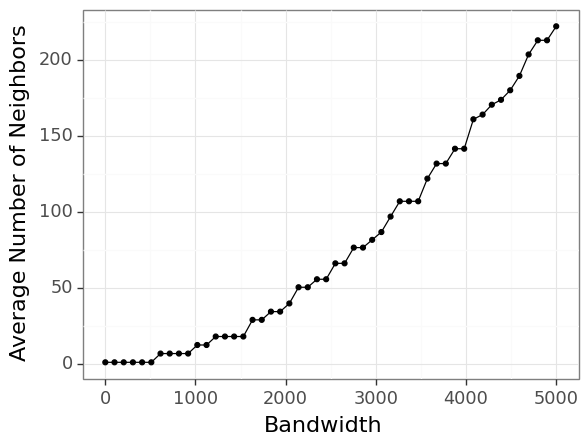

<ggplot: (8741818381826)>

In [63]:
p

In [56]:
reference = mdata.mod["msi"].obsm["spatial"]

In [57]:
coordinates = mdata.mod["rna"].obsm["spatial"]

In [64]:
p, df = query_bandwidth(coordinates, start=300, end=5000, interval_n=50, reference=reference)